# A/B Testing for Mobile Games
Dataset can be found here: https://www.kaggle.com/arpitdw/cokie-cats?select=cookie_cats.csv

There is mobile phone game where the player solves a puzzle to move on to the next level. After x amount of level there is a 'gate' that forces the player to wait and watch an ad or have the player pay to remove the gate. This dataset contains the results of an A/B test where the gate is placed at level 30 for some amount of players and level 40 for the remaining players. We will dive it on how this makes an impact on player retention. First let's take a glance at the data and its fields!

- userid - A unique id that identifies each player.
- version - which A/B test group were they in?
- sum_gamerounds - The number of game rounds played by the player during the first 14 days.
- retention_1 - Is thie player still gaming after 1 day?
- retention_7 - Is thie player still gaming after 7 days?

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


# How many players have their gate at level 30 vs level 40?

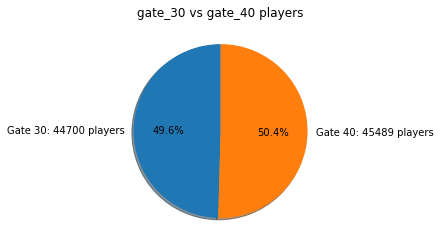

In [2]:
# Get the count of players in each group
gate30_cnt = df.groupby('version')['userid'].count()[0]
gate40_cnt = df.groupby('version')['userid'].count()[1]

gate30_label = 'Gate 30: {} players'.format(gate30_cnt)
gate40_label = 'Gate 40: {} players'.format(gate40_cnt)
labels = [gate30_label, gate40_label]

fig1, ax1 = plt.subplots()
ax1.pie([gate30_cnt, gate40_cnt], labels=labels, shadow=True, startangle=90, autopct='%1.1f%%')
plt.title('gate_30 vs gate_40 players')
plt.show()

# What round are players leaving the game?

In [3]:
rounds = df.groupby('sum_gamerounds')['userid'].count()
rounds

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

Text(0, 0.5, 'User Count')

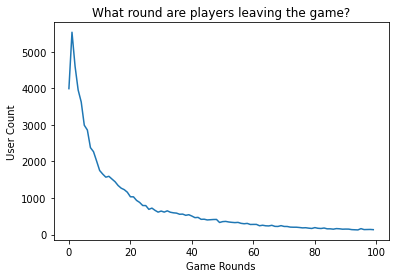

In [4]:
ax = rounds.head(n=100).plot(x='sum_gamerounds', y='userid')
ax.set_title('What round are players leaving the game?')
ax.set_xlabel('Game Rounds')
ax.set_ylabel('User Count')

# What percent of total players come back the next day?

In [5]:
retetion1_sum = df['retention_1'].sum() / df['retention_1'].count()
'{:.1%}'.format(retetion1_sum)

'44.5%'

# What percent of 'gate_30' vs 'gate_40' players come back the next day? What about the next 7 days?

In [6]:
# Find the number of players that came back after 1 day and group them by the version they are using.
retetion1_sum_per_version = df.groupby('version')['retention_1'].sum()
retetion1_sum_per_version

version
gate_30    20034
gate_40    20119
Name: retention_1, dtype: int64

In [7]:
# Find total players in different versions of the game.
total_players = df.groupby('version')['userid'].count()
total_players

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

In [8]:
# Find percentage of players that come back after one day.
# gate_40 has a lower retention rate
retetion1_sum_per_version / total_players

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

In [9]:
# Find the number of players that came back after 7 days and group them by the version they are using.
# gate_40 has a lower retention rate AGAIN! Even after 7 days.
retetion7_sum_per_version = df.groupby('version')['retention_7'].sum()
retetion7_sum_per_version

version
gate_30    8502
gate_40    8279
Name: retention_7, dtype: int64

In [10]:
# Find percentage of players that come back after seven day.
retetion7_sum_per_version / total_players

version
gate_30    0.190201
gate_40    0.182000
dtype: float64

# Bootstrapping to be certain of our results. We will resample the dataset 90189 times (Same size as the original dataset) and get the retention 1 and 7 means. We will do that 1000 times and put that mean into a DataFrame to make a Kernel Density Estimate plot of the bootstrap distributions

In [ ]:
# Creating an list with bootstrapped means for each AB-group
# Reference: https://www.youtube.com/watch?v=gcPIyeqymOU
# frac=1 items returned is the same as the original dataset.
# replace=True allows sampling of the same row more than once.

boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot for 1 day retentions
boot_1d.plot(kind='kde')

In [ ]:
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# A Kernel Density Estimate plot for 7 day retentions
boot_7d.plot(kind='kde')

# Let's take a look at the difference of means

In [ ]:
# Take a glance at the data
boot_1d.head()

In [ ]:
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_title('Difference in Means of 1 Day Retention')
ax.set_xlabel("% difference in means")

In [ ]:
# Take a glance at the data
boot_7d.head()

In [ ]:
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_title('Difference in Means of 7 Day Retention')
ax.set_xlabel("% difference in means")

 # The probability of a difference

In [ ]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).mean()

# Pretty printing the probability
'{:.1%}'.format(prob)

In [ ]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).mean()

# Pretty printing the probability
'{:.1%}'.format(prob)

# Recommendation is to use the gate at level 30 since the retention rate is higher in both cases.